# **Subset a CONUS2.1 domain for ParFlow simulation**
This notebook subsets a CONUS2.1 domain to be used for training and testing the 1-ts emaultor. 

It sets up the files needed for a ParFlow-CLM CONUS2.1 run.

#### Inputs needed for training: 
**Transient:** 
- forcing

**Static inputs:** 
- slopes: x & y (2*2D)
- Perm: Kx, ky & Kz (3*3D) (we have just need to be added)
- Porosity (1*3D) (we have just need to be added)
- Van Genuchten (4*3D) (sres, ssat, alpha, n)
- Specific Storage (1*3D)
- Mannings (1*2D)
- Flow barrier
- CLM veg m
  

## 1. Import the required libraries and set hydrodata PIN

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
from parflow import Run
from parflow.tools.io import read_pfb, read_clm, write_pfb
from parflow.tools.fs import mkdir
from parflow.tools.settings import set_working_directory
import subsettools as st
import hf_hydrodata as hf
import glob

In [ ]:
# You need to register on https://hydrogen.princeton.edu/pin before you can use the hydrodata utilities
email = input('Enter your hydrgen email address')
pin = input('Enter your hydrogen PIN')
print('Registering ' + email + ' (PIN=' + pin + ') for HydroData download' ) 
hf.register_api_pin(email, pin)

## 2. Setup and user variables

### 2.1 User varibles
Test locations: 
- Upper Eel (HUC18010103) outlets = [[39.69982997,-123.35758209]]
- East Taylor (HUC14020001),  outlets=[[38.66253817,-106.84684753]]
- Conemaugh (HUC 05010007), outlets=[[40.48471460,-79.43527222]]
- Granite Spring (HUC16050104) --Haven't done the outlet for this one yet

In [4]:
run_name = "Upper_Eel"
base_dir = os.path.join("/home/lc2465/NAIRR/test_domains")
outlets = [[39.69982997,-123.35758209]] #watershed will be defined by upstream area

# Date range for forcing files 
# (This is also used as initial settins for CLM driver files)
start = "2002-10-01"
end = "2003-10-01"
forcing_name = "WY2003" #This will be the name for the folder they are put in

#Initial condition file to use and dataset to grab from
wy = 2024
wy_hour = 8784
pf_ic_source_name = "WY2024_V1"

#List of dataset to use static variables to subset
grid = "conus2"
var_ds = "conus2_domain" #Dataset to get static variables from
variable_list=['slope_x', 'slope_y', 'pme', 'ss_pressure_head', 'pf_indicator', 'pf_flowbarrier', 
               'mannings']

### 2.2 Setup the directories to put things in

In [5]:
static_write_dir = os.path.join(base_dir, run_name, "static_inputs")
mkdir(static_write_dir)
forcing_write_dir = os.path.join(base_dir, run_name, "forcings",  forcing_name)
mkdir(forcing_write_dir)
transient_write_dir = os.path.join(base_dir, run_name, "transient_runs")
mkdir(transient_write_dir)

### 2.3 Get ParFlow bounding box from upstream area point 

In [ ]:
ij_upstream_area_bounds, mask = st.define_upstream_domain(outlets=outlets, grid="conus2")
print(f"bounding box: {ij_upstream_area_bounds}")
print("Here")
ij_bounds = ij_upstream_area_bounds
print(ij_bounds)

nj = ij_upstream_area_bounds[3] - ij_upstream_area_bounds[1]
ni = ij_upstream_area_bounds[2] - ij_upstream_area_bounds[0]
print(f"nj: {nj}")
print(f"ni: {ni}")

# plot the mask
plt.imshow(mask, origin="lower")


## 3. Subset model files

### 3.1 Subset static inputs, clm files and make solid file

In [12]:
# Subset static ParFlow Files
static_paths = st.subset_static(ij_bounds, dataset=var_ds,  
                                write_dir=static_write_dir, var_list=variable_list)
print(ij_bounds)

# Subset CLM files
clm_paths = st.config_clm(ij_bounds, start=start, end=end, dataset=var_ds, write_dir=static_write_dir)

# Make solid file
mask_solid_paths = st.write_mask_solid(mask=mask, grid=grid, write_dir=static_write_dir)

/tmp/ipykernel_452621/3325509484.py:2: DeprecationWarning: Note that for subsettools versions >= 2.0.0, this function will raise a ValueError if a variable in var_list is not supported in the dataset. (In older versions, it just printed an error message and continued executing normally). You can check in the HydroData documentation which variables are contained in each dataset (https://hf-hydrodata.readthedocs.io/en/latest/available_data.html).
  static_paths = st.subset_static(ij_bounds, dataset=var_ds,


Wrote slope_x.pfb in specified directory.
Wrote slope_y.pfb in specified directory.
Wrote pme.pfb in specified directory.
Wrote ss_pressure_head.pfb in specified directory.
Wrote pf_indicator.pfb in specified directory.
Wrote pf_flowbarrier.pfb in specified directory.
Wrote mannings.pfb in specified directory.
(42, 1932, 106, 1994)
copied vegp
subset vegm
copied drv_clmin
edited drv_clmin
Wrote mask.pfb
Wrote solidfile and mask_vtk with total z of 2000 meters


### 3.2 Clip the initial pressure file

Reading Initial pressure file: /hydrodata/temp/CONUS2.1/WY2024_V1/raw_outputs/conus21.wy2024.out.press.08784.pfb


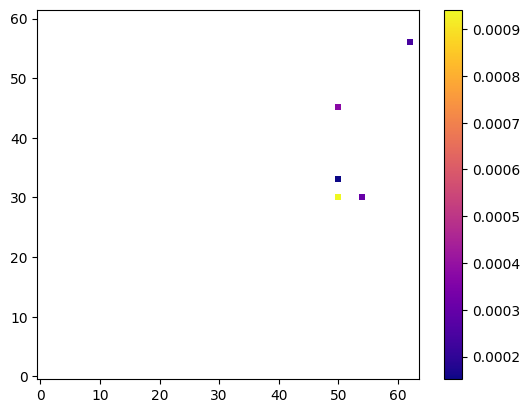

In [13]:
#Read in the pressure file
fin1= f"/hydrodata/temp/CONUS2.1/{pf_ic_source_name}/raw_outputs/conus21.wy{wy}.out.press.{wy_hour:05d}.pfb"
print("Reading Initial pressure file:", fin1)
#fin1= f"/hydrodata/temp/CONUS2.1/WY2003_V2/raw_outputs/conus21.wy{wy}.out.press.{wy_hour:05d}.pfb"
IC = read_pfb(fin1)

#Clip and write out the subset
Upper_Eel_IC = IC[:,ij_bounds[1]:ij_bounds[3],ij_bounds[0]:ij_bounds[2]]
write_pfb(static_write_dir+"/press_in.pfb", Upper_Eel_IC, p=1,
    q=1,
    r=1,
    x=0.0,
    y=0.0,
    z=0.0,
    dx=1000.0,
    dy=1000.0,
    dz=200.0)

plot_surface = Upper_Eel_IC[9,:,:]
plot_surface[plot_surface < .0] = np.nan
plt.imshow(plot_surface, origin='lower', cmap='plasma') #,vmin = 0, vmax = 10) #,norm=colors.LogNorm(vmin = 1e-8, vmax = 10),interpolation='none')
#plt.axis('off')
plt.colorbar()
plt.show()

### 3.3 Clip stream segments and DEM for reference

(62, 64)
26319.0 0.0


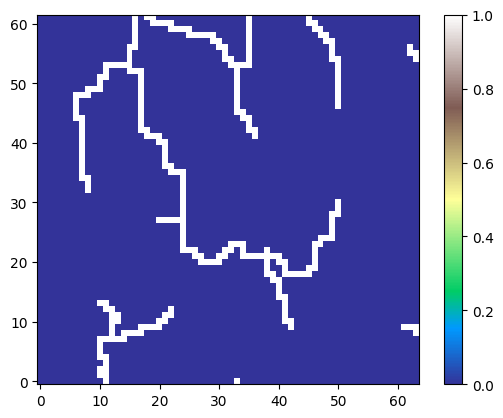

(62, 64)


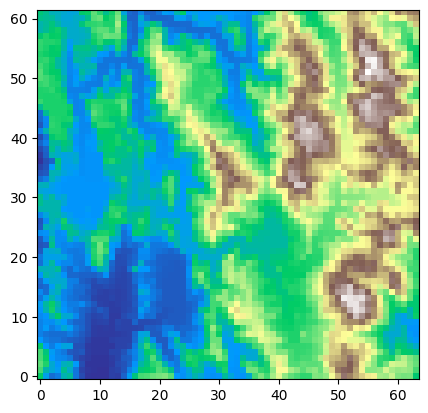

In [14]:
#### Stream segments

#clip the streams
options = {"dataset":var_ds, "variable":"stream_segments", "grid_bounds":ij_bounds }
stream_HUC = hf.get_gridded_data(options)

#plot the streams
print(stream_HUC.shape)
print(np.max(stream_HUC), np.min(stream_HUC))
# map stream segments to values of 1
stream_HUC[stream_HUC>0] = 1
# plot the streams
str= plt.imshow(stream_HUC, cmap="terrain", origin="lower") 
plt.colorbar(str, ax=plt.gca())
plt.show()

#write the streams
write_pfb(static_write_dir+"/streams.pfb", stream_HUC, p=1,
    q=1,
    r=1,
    x=0.0,
    y=0.0,
    z=0.0,
    dx=1000.0,
    dy=1000.0,
    dz=0.1)

### DEM
# clip the dem
options = {"dataset":var_ds, "variable":"elevation", "grid_bounds":ij_bounds }
dem = hf.get_gridded_data(options)

# plot the dem
plt.imshow(dem, cmap="terrain", origin="lower")

#write the dem
write_pfb(static_write_dir+"/dem.pfb", dem, p=1,
    q=1,
    r=1,
    x=0.0,
    y=0.0,
    z=0.0,
    dx=1000.0,
    dy=1000.0,
    dz=0.1)
print(dem.shape)


## OPTIONAL CROSS CHECK
# Test cross checking with a manual clip from the CONUS files
#file = "/hydrodata/PFCLM/CONUS2_baseline/inputs/topography_files/1km/CONUS2.0.Final1km.StreamSegments.pfb"
#streams = read_pfb(file)
#stream_clip = streams[0,ij_bounds[1]:ij_bounds[3],ij_bounds[0]:ij_bounds[2]]
#print(stream_clip.shape)
#print(np.max(stream_clip), np.min(stream_clip))
#stream_clip[stream_clip>0] = 1

# plot the streams
#str= plt.imshow(stream_clip, cmap="terrain", origin="lower") 
#plt.colorbar(str, ax=plt.gca())
#plt.show()

## 4. Subset transient Forcing files


In [15]:
# Example grabbing all 8 forcing variables
filepaths = st.subset_forcing(
    ij_bounds,
    grid="conus2",
    start=start,
    end=end,
    dataset="CW3E",
    write_dir=forcing_write_dir,
)

Reading atmospheric_pressure pfb sequence
Reading downward_shortwave pfb sequence
Reading downward_longwave pfb sequence
Reading east_windspeed pfb sequence
Reading precipitation pfb sequence
Reading specific_humidity pfb sequence
Reading air_temp pfb sequence
Reading north_windspeed pfb sequence
Finished writing precipitation to folder
Finished writing downward_shortwave to folder
Finished writing east_windspeed to folder
Finished writing north_windspeed to folder
Finished writing atmospheric_pressure to folder
Finished writing downward_longwave to folder
Finished writing air_temp to folder
Finished writing specific_humidity to folder
